<a href="https://colab.research.google.com/github/OskarKrafft/Machine-Learning-Project/blob/main/notebooks/07_SHAP_presentation_blogpost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/Machine-Learning-Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Machine-Learning-Project


In [2]:
# Change working directory to project folder
%cd /content/drive/MyDrive/Colab Notebooks/Machine-Learning-Project

/content/drive/MyDrive/Colab Notebooks/Machine-Learning-Project


## Import Test Data

In [3]:
# Importing the data
import pandas as pd
eppes_cleaned = pd.read_csv('./data/processed/eppes_cleaned.csv')
eppes_cleaned = eppes_cleaned.drop(eppes_cleaned.columns[0], axis = 1)

# Import Excel sheet containing column indeces to be dropped
columns_analysis = pd.read_excel('./data/interim/Drop_Columns_categorical.xlsx')
columns_analysis = columns_analysis.drop(columns_analysis.columns[[0]], axis = 1)

# Create list of names of categorical columns 
col_names_categorical = []
for i in range(872):
  if columns_analysis.iloc[i, 3] == 'categorical':
    col_names_categorical.append(columns_analysis.iloc[i, 1])

# Change datatype of categorical variables to object
eppes_cleaned[col_names_categorical] = eppes_cleaned[col_names_categorical].astype('object')

In [4]:
eppes_cleaned.rename(columns={'qg15': 'Voted in national elections', 
                              'd1': 'Political left-right scale', 
                              'd72_1': 'Voice counts in the EU', 
                              'd72_2': 'Voice counts in country', 
                              'd11': 'Age', 
                              'd71a_2': 'Discuss European politics', 
                              'd71a_1': 'Discuss national politics', 
                              'qg13_3': 'Read written press', 
                              'qf1': 'Opinion EU membership',
                              'd71a_3': 'Discuss local politics'}, inplace=True)

In [5]:
# Define X and y
print(eppes_cleaned.head())
X = eppes_cleaned.drop(columns='qg1') # reference variable which contains voted y/n
y = eppes_cleaned['qg1'] # reference variable which contains voted y/n

# 80/20 train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state=123)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)

y_test_df = pd.DataFrame(data=y_test)
y_test_df.value_counts(normalize=True)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

y_train_df = pd.DataFrame(data=y_train)
y_train_df.value_counts(normalize=True)

# Setting up pre-processing pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Identify all categorical variables by data type
categorical_X_features = X_test.select_dtypes(include=['object', 'bool']).columns

# OneHotEncode all categorical variables
categorical_transformer = OneHotEncoder(handle_unknown="error")

preprocessor = ColumnTransformer(remainder = 'passthrough', # remainder = passthrough for numerical variables to be kept unchanged
    transformers=[
        ("cat", categorical_transformer, categorical_X_features)]
)
# Inspect the number of variables after pre-processing

# Fit the pipeline to the testing data
preprocessor.fit(X_test)
X_test_ = preprocessor.transform(X_test)

# Fit the pipeline to the training data
preprocessor.fit(X_train)
X_train_ = preprocessor.transform(X_train)

   q1.1  q1.2  q1.3  q1.4  q1.5  q1.6  q1.7  q1.8  q1.9  q1.10  ...  d43a  \
0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ...   2.0   
1   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0    0.0  ...   2.0   
2   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ...   2.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  ...   1.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0    0.0  ...   2.0   

   d43b  d46.8  d60  d62_1  d62_2  d63  Voice counts in the EU  \
0   1.0    1.0  1.0    3.0    6.0  1.0                     3.0   
1   1.0    1.0  3.0    2.0    6.0  3.0                     2.0   
2   2.0    1.0  1.0    1.0    5.0  2.0                     2.0   
3   1.0    1.0  2.0    1.0    1.0  3.0                     2.0   
4   1.0    1.0  1.0    1.0    5.0  2.0                     2.0   

   Voice counts in country  d77  
0                      3.0  2.0  
1                      2.0  3.0  
2                      2.0  1.0  
3   

In [ ]:
y_test[421]

## Import Models

In [6]:
from sklearn.ensemble import RandomForestClassifier

best_rf = RandomForestClassifier(max_depth = 30, n_estimators = 300, min_samples_split = 5, min_samples_leaf = 1, max_features = "sqrt", random_state = 123)

In [7]:
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,
                       n_estimators=300, random_state=123)

In [8]:
y_pred_rf = best_rf.predict(X_test)

In [9]:
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score, precision_score, recall_score
mcc = []
f1 = []

mcc.append((matthews_corrcoef(y_test, y_pred_rf)))
f1.append((f1_score(y_test, y_pred_rf)))

In [10]:
f1

[0.8014513202983271]

In [11]:
mcc

[0.638276425325481]

## TreeSHAP: Global feature importance

In [12]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
# Import shap

import shap

In [14]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(best_rf)

In [15]:
# Calculate shap values
shap_values = explainer.shap_values(X_test)

In [17]:
import matplotlib.pyplot as plt

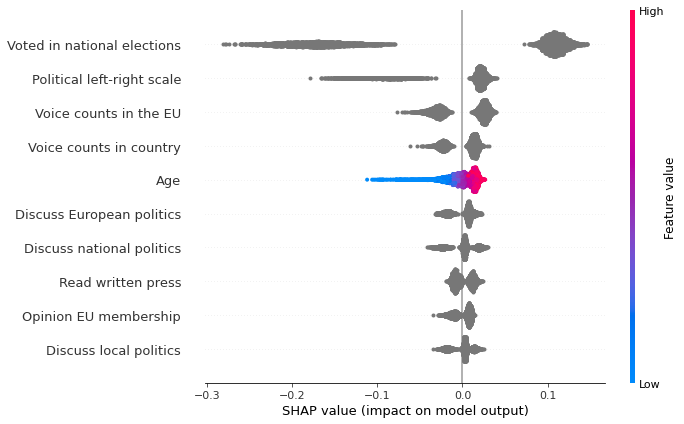

In [32]:
# Make summary plot for class voted
shap.summary_plot(shap_values[0], X_test, max_display=10, show=False, plot_size = (10,6))
#ax = plt.gca()

# You can change the min and max value of xaxis by changing the arguments of:
#ax.set_xlim(-0.3, 0.3) 
#plt.show()



plt.savefig('treeshap_global_10_beeswarm_presentation.png', bbox_inches="tight", dpi = 144)

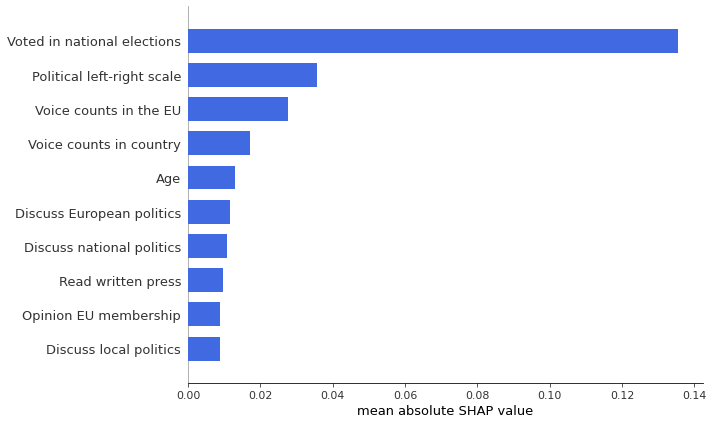

In [46]:
# Create global feature importance

shap.summary_plot(shap_values[1], X_test, max_display = 10, show = False, plot_type='bar', plot_size = (10,6), color = "royalblue")

# Get the current figure and axes objects.
fig, ax = plt.gcf(), plt.gca()

ax.set_xlabel("mean absolute SHAP value (average impact on model output magnitude)")

plt.savefig('treeshap_global_10_bar.png', bbox_inches="tight", dpi = 144)

## Shap 

In [ ]:
import numpy
X_train = numpy.array(X_train,dtype='float64')

In [ ]:
shap_explainer = shap.Explainer(best_rf)
shap_test = shap_explainer(X_test)

In [ ]:
import matplotlib.pyplot as plt

shap_global_50 = shap.plots.bar(shap_test[:, :, 1], max_display=50, show=False)
plt.savefig('shap_global_50_bar.png', bbox_inches="tight", dpi = 144)

In [ ]:
shap_global_10 = shap.plots.bar(shap_test[:, :, 1], max_display=10, show=False)

plt.savefig('shap_global_10_bar.png', bbox_inches="tight", dpi = 144)

In [ ]:
shap_global_20 = shap.plots.bar(shap_test[:, :, 1], max_display=20, show=False)
plt.savefig('shap_global_20_bar.png', bbox_inches="tight", dpi = 144)

In [ ]:
shap_local_10 = shap.plots.bar(shap_test[:, :, 1][421], max_display=10, show=False)
plt.savefig('shap_local_10_bar.png', bbox_inches="tight", dpi = 144)

In [ ]:
shap_local_10 = shap.plots.waterfall(shap_test[:, :, 1][421], max_display=10, show=False)
plt.savefig('shap_local_10_waterfall.png', bbox_inches="tight", dpi = 144)

In [ ]:
shap_local_20 = shap.plots.bar(shap_test[:, :, 1][421], max_display=20, show=False)
plt.savefig('shap_local_20_bar.png', bbox_inches="tight", dpi = 144)